## 1. Descarga y Preparación del Dataset

In [1]:
import os
import json

## 2. Exploración de Datos


In [ ]:
'''
En este paso se eliminan las etiquetas que no son de interés
y se renumeran las etiquetas restantes.
Las etiquetas de interés son:
    2: '0' (carretera)
    3: '1' (río)
'''

import os

source_root = 'data/Etiquetas'
destination_root = 'data/EtiquetasProcesadas'
keep_classes = {'2': '0', '3': '1'}
subdirs = ['train', 'test', 'val']

for subdir in subdirs:
    for root, _, files in os.walk(os.path.join(source_root, subdir)):
        for file in files:
            if file.endswith('.txt'):
                source_path = os.path.join(root, file)
                rel_path = os.path.relpath(source_path, source_root)
                dest_path = os.path.join(destination_root, rel_path)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)

                with open(source_path, 'r') as src_file:
                    lines = src_file.readlines()

                new_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if parts and parts[0] in keep_classes:
                        parts[0] = keep_classes[parts[0]]
                        new_lines.append(' '.join(parts))

                with open(dest_path, 'w') as dest_file:
                    dest_file.write('\n'.join(new_lines) + '\n' if new_lines else '')


In [30]:
import os
import shutil

# Paths
labels_root = 'data/EtiquetasProcesadas'
images_root = 'data/Procesado/'
output_root = 'data/ImagenesFiltradas'

image_extensions = ['.jpg']
subdirs = ['train', 'test', 'val']

for subdir in subdirs:
    labels_subdir = os.path.join(labels_root, subdir)
    images_subdir = os.path.join(images_root, subdir)
    output_labels_subdir = os.path.join(output_root, subdir, 'labels')
    output_images_subdir = os.path.join(output_root, subdir, 'images')

    os.makedirs(output_labels_subdir, exist_ok=True)
    os.makedirs(output_images_subdir, exist_ok=True)

    for root, _, files in os.walk(labels_subdir):
        for file in files:
            if file.endswith('.txt'):
                label_path = os.path.join(root, file)

                with open(label_path, 'r') as f:
                    lines = [line.strip() for line in f if line.strip()]

                if lines:
                    rel_path = os.path.relpath(label_path, labels_root)
                    rel_base = os.path.splitext(rel_path)[0]
                    new_label_path = os.path.join(output_labels_subdir, os.path.basename(rel_path))
                    shutil.copy(label_path, new_label_path)

                    for ext in image_extensions:
                        image_path = os.path.join(images_subdir, os.path.basename(rel_base) + ext)
                        if os.path.exists(image_path):
                            new_image_path = os.path.join(output_images_subdir, os.path.basename(rel_base) + ext)
                            shutil.copy(image_path, new_image_path)
                            break


In [ ]:
from pathlib import Path
FILTERED_IMAGES = Path('data/ImagenesFiltradas/')
if not FILTERED_IMAGES.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {FILTERED_IMAGES}")

                                count
ImagenesFiltradas/train/images    610
ImagenesFiltradas/val/images       74
ImagenesFiltradas/test/images     226


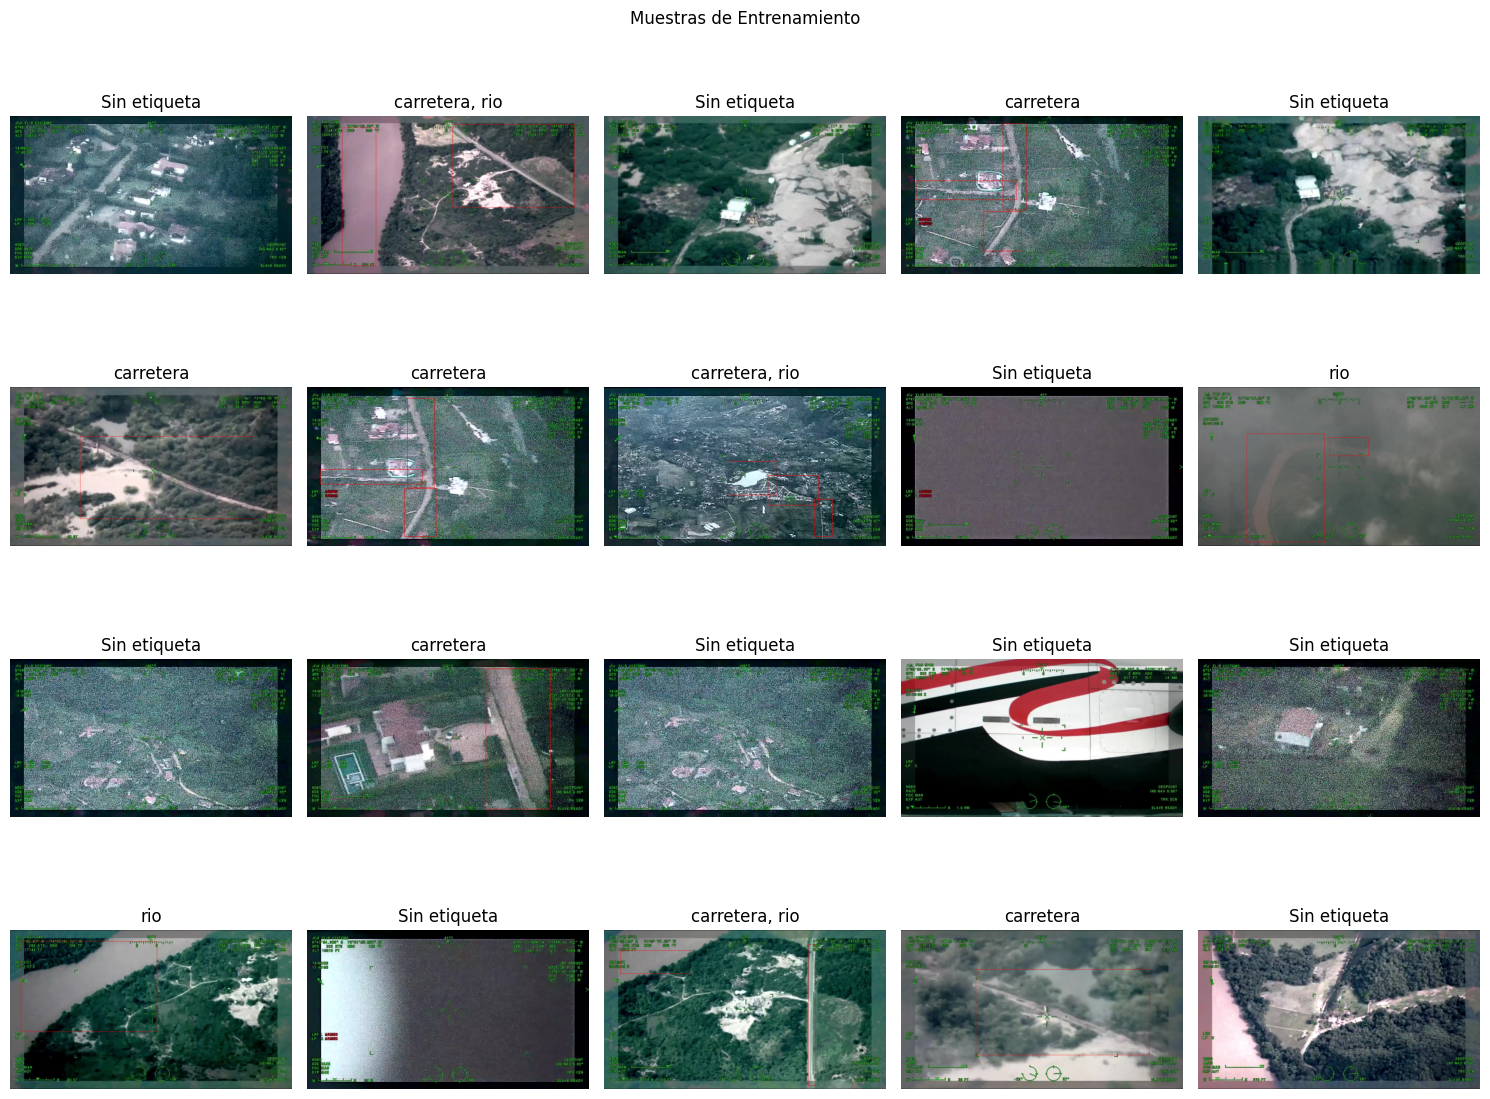

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

DATA_ROOT = Path('data/')
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {DATA_ROOT}")

root = DATA_ROOT
train_img = root / 'Imagenes' / 'train'
train_lbl = root / 'EtiquetasProcesadas' / 'train'

# Definir clases
class_names = [
    'carretera', 'rio'
]

# 1. Conteo de imágenes y distribución numérica
counts = {}
for split in ['ImagenesFiltradas/train/images', 'ImagenesFiltradas/val/images', 'ImagenesFiltradas/test/images']:
    path = root / split 
    counts[split] = len(list(path.glob('*.*'))) if path.exists() else 0

# Mostrar tabla de distribución
dist = pd.Series(counts, name='count')
print(dist.to_frame())

# 2. Visualizar muestras con bounding boxes y título de clase
population = list(train_img.glob('*.*'))
if not population:
    raise FileNotFoundError(f"No se encontraron imágenes en {train_img}")

# Tomar hasta 20 muestras
k = min(20, len(population))
sample_images = random.sample(population, k)

n_cols = 5
n_rows = (k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for ax, img_path in zip(axes.flatten(), sample_images):    
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    lbl_path = train_lbl / f"{img_path.stem}.txt"
    title_labels = set()
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            cls, x_c, y_c, bw, bh = map(float, line.split())
            # Convertir a coordenadas de pixeles
            cx, cy = x_c * w, y_c * h
            bw_pix, bh_pix = bw * w, bh * h
            x1, y1 = cx - bw_pix/2, cy - bh_pix/2
            x2, y2 = cx + bw_pix/2, cy + bh_pix/2
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            title_labels.add(class_names[int(cls)])

    ax.imshow(img)
    ax.set_title(", ".join(sorted(title_labels)) or "Sin etiqueta")
    ax.axis('off')

# Ocultar ejes sobrantes
for ax in axes.flatten()[k:]:
    ax.axis('off')

plt.suptitle('Muestras de Entrenamiento')
plt.tight_layout()
plt.show()

## 3. Preprocesamiento y YAML

En esta sección, se realiza la configuración necesaria para que el modelo YOLO pueda utilizar el conjunto de datos. Esto incluye:

1. **Definición de las clases**: Se especifican las categorías de objetos que el modelo debe detectar. En este caso, las clases corresponden a diferentes tipos de animales, como "Buffalo", "Camel", "Cat", entre otros.

2. **Creación del archivo YAML**: Este archivo es esencial para entrenar modelos YOLO, ya que define la estructura del conjunto de datos. Contiene información como:
   - La ruta base del conjunto de datos.
   - Las particiones de entrenamiento, validación y prueba.
   - El número total de clases (`nc`).
   - Los nombres de las clases (`names`).

El archivo YAML asegura que el modelo pueda interpretar correctamente las imágenes y etiquetas durante el entrenamiento y la evaluación.

In [33]:
yaml_content = f"""
path: {FILTERED_IMAGES.absolute()}
train: train/images
val:   val/images
test:  test/images

nc: {len(class_names)}
names: {class_names}
""".strip()
with open(DATA_ROOT / 'rio-carretera-differentiation.yaml', 'w') as f:
    f.write(yaml_content)

## 4 Arquitectura de YOLO

YOLO (“You Only Look Once”) cambió el paradigma de la detección de objetos al combinar en una sola red la localización y clasificación de instancias, evitando las etapas separadas de propuestas y refinamiento de métodos como R-CNN. Fue introducido por Redmon et al. en 2016 en *“You Only Look Once: Unified, Real-Time Object Detection”* ([ver paper](https://arxiv.org/abs/1506.02640)). Su flujo de datos se compone de:

1. **Backbone**  
   Una CNN profunda que extrae mapas de características a varios niveles de abstracción. En las familias modernas de YOLO suele emplearse CSPDarknet, que reduce la redundancia de gradiente y acelera el entrenamiento.

2. **Neck**  
   Una red de agregación multiescala (por ejemplo PANet o BiFPN) que fusiona los mapas del Backbone para capturar tanto objetos pequeños como grandes de forma eficiente.

3. **Head**  
   La capa final divide el mapa en una cuadrícula y, para cada celda, predice varias cajas delimitadoras, su confianza y la distribución de clases. Aplica Non-Max Suppression para filtrar solapamientos.

> A modo de ejemplo, la siguiente ilustración muestra el esquema general de YOLOv11, con sus tres bloques principales:
>  
> ![Arquitectura YOLOV11](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*L8rMuwurmyBH1ixIqcrMSQ.png)  

### Variantes de YOLOv11

Para distintos balances de velocidad y precisión, YOLOv11 ofrece cinco tamaños preentrenados:

| Variante      | Parámetros aproximados | Uso recomendado                         |
|---------------|------------------------|-----------------------------------------|
| **v11n** (nano)   | ~2.6 M                   | Dispositivos edge, prototipado rápido    |
| **v11s** (small)  | ~9.4 M                   | Móviles, aplicaciones con recursos limitados |
| **v11m** (medium) | ~20.1 M                  | GPU de nivel medio, tareas generales     |
| **v11l** (large)  | ~25.3 M                  | Servidores potentes, máxima precisión     |
| **v11x** (XL)     | ~56.9 M                  | Investigación o despliegue en datacenter  |

En este laboratorio emplearemos **YOLOv11s**, que ofrece un buen compromiso entre velocidad de entrenamiento, latencia de inferencia y calidad de detección.


# 5. Entrenamiento del Modelo

Entrenaremos la variante **small** de YOLOv11 en el conjunto de datos de detección de animales.

Para obtener el modelo preentrenado de las diferentes variantes de YOLOv11, tenemos las siguientes opciones:

- `yolo11n.pt` — **nano**
- `yolo11s.pt` — **small**
- `yolo11m.pt` — **medium**
- `yolo11l.pt` — **large**
- `yolo11x.pt` — **extra large**

In [ ]:
%pip install ultralytics --upgrade --quiet

In [43]:
from ultralytics import YOLO
import time

# Cargar modelo base
model = YOLO('yolo11s.pt')

start = time.time()

# Entrenar
results = model.train(
    data=str(root / 'rio-carretera-differentiation.yaml'),
    epochs=50,
    imgsz=640,
    batch=16,
    patience=8,
    name='flir_yolov11s',
    augment=True 
)


end = time.time()
print(f"Execution time: {end-start}")

Ultralytics 8.3.128 🚀 Python-3.9.18 torch-2.7.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/rio-carretera-differentiation.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=flir_yolov11s2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

train: Scanning /Users/juan/Local/2025-10loc/ISIS4825/proyecto/repositorio/data/ImagenesFiltradas/train/labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 850.5±263.7 MB/s, size: 378.4 KB)



val: Scanning /Users/juan/Local/2025-10loc/ISIS4825/proyecto/repositorio/data/ImagenesFiltradas/val/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]

Plotting labels to /opt/homebrew/runs/detect/flir_yolov11s2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /opt/homebrew/runs/detect/flir_yolov11s2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.316      3.795       2.24          7        640: 100%|██████████| 39/39 [09:05<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.30s/it]

                   all         74        124       0.18      0.145     0.0979     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.313      2.836      2.177          9        640: 100%|██████████| 39/39 [08:31<00:00, 13.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.79s/it]

                   all         74        124     0.0714      0.169     0.0371    0.00946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/50         0G      2.338      2.748      2.175          8        640: 100%|██████████| 39/39 [08:12<00:00, 12.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.81s/it]

                   all         74        124     0.0558      0.161     0.0685     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.302      2.696      2.147         10        640: 100%|██████████| 39/39 [08:09<00:00, 12.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.89s/it]

                   all         74        124      0.621      0.113     0.0912     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.299      2.627       2.15         15        640: 100%|██████████| 39/39 [08:07<00:00, 12.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.79s/it]

                   all         74        124      0.565      0.153     0.0871     0.0225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/50         0G      2.228      2.531       2.11         11        640: 100%|██████████| 39/39 [08:15<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.71s/it]

                   all         74        124      0.344      0.238      0.148     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.179      2.488      2.054          2        640: 100%|██████████| 39/39 [08:27<00:00, 13.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.72s/it]

                   all         74        124      0.124      0.355      0.101     0.0299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50         0G      2.144      2.398      2.037         12        640: 100%|██████████| 39/39 [08:13<00:00, 12.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.322      0.565      0.276     0.0907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/50         0G      2.164      2.389      2.031          6        640: 100%|██████████| 39/39 [08:25<00:00, 12.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.83s/it]

                   all         74        124      0.443      0.395      0.389      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.097      2.294      1.977          5        640: 100%|██████████| 39/39 [08:46<00:00, 13.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.67s/it]

                   all         74        124      0.452      0.379      0.335      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.073      2.254      1.964          5        640: 100%|██████████| 39/39 [08:36<00:00, 13.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.64s/it]

                   all         74        124      0.378      0.492      0.335       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/50         0G      2.017      2.176      1.898          6        640: 100%|██████████| 39/39 [08:39<00:00, 13.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.64s/it]

                   all         74        124      0.413      0.387      0.339      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/50         0G      2.043       2.22      1.903          5        640: 100%|██████████| 39/39 [08:42<00:00, 13.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.70s/it]

                   all         74        124      0.272      0.476      0.214     0.0798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/50         0G      2.011      2.128      1.901         10        640: 100%|██████████| 39/39 [08:38<00:00, 13.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.689      0.427      0.504      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.011      2.109      1.921          9        640: 100%|██████████| 39/39 [08:30<00:00, 13.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]

                   all         74        124      0.524      0.371      0.323      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50         0G      1.993      2.071      1.869          4        640: 100%|██████████| 39/39 [08:25<00:00, 12.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.517       0.46      0.415      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/50         0G      1.963      2.035      1.856         11        640: 100%|██████████| 39/39 [08:32<00:00, 13.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.65s/it]

                   all         74        124      0.592      0.492      0.494      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.977      2.007      1.835          4        640: 100%|██████████| 39/39 [08:10<00:00, 12.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.542      0.556      0.492      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/50         0G      1.933      1.995      1.827          8        640: 100%|██████████| 39/39 [08:15<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.541      0.476       0.45      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/50         0G      1.903       1.93      1.775          9        640: 100%|██████████| 39/39 [08:08<00:00, 12.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.606      0.579      0.532      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.859      1.874      1.765         11        640: 100%|██████████| 39/39 [08:15<00:00, 12.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]

                   all         74        124      0.572      0.508      0.503      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/50         0G      1.818      1.832      1.745         10        640: 100%|██████████| 39/39 [08:08<00:00, 12.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.73s/it]

                   all         74        124      0.704      0.575      0.568      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.848      1.833      1.742          8        640: 100%|██████████| 39/39 [08:19<00:00, 12.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

                   all         74        124      0.614      0.573      0.585      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.849      1.804      1.749          4        640: 100%|██████████| 39/39 [08:13<00:00, 12.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]

                   all         74        124      0.511      0.556      0.425      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/50         0G      1.823      1.781       1.74         17        640: 100%|██████████| 39/39 [08:22<00:00, 12.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]

                   all         74        124      0.784      0.597      0.627      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.771      1.741      1.692         13        640: 100%|██████████| 39/39 [08:34<00:00, 13.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]

                   all         74        124      0.747      0.581      0.601      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.765      1.665      1.664         10        640: 100%|██████████| 39/39 [08:09<00:00, 12.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.67s/it]

                   all         74        124      0.581      0.548      0.558      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/50         0G      1.743      1.673       1.67          8        640: 100%|██████████| 39/39 [08:22<00:00, 12.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.65s/it]

                   all         74        124      0.686      0.573       0.58      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/50         0G      1.712      1.641      1.655          8        640: 100%|██████████| 39/39 [08:38<00:00, 13.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.76s/it]

                   all         74        124      0.569      0.629      0.581      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.753      1.607      1.657          8        640: 100%|██████████| 39/39 [08:22<00:00, 12.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.65s/it]

                   all         74        124      0.498      0.556      0.454      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.703      1.589       1.65          8        640: 100%|██████████| 39/39 [08:13<00:00, 12.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]

                   all         74        124      0.761      0.632      0.639      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.737      1.594      1.651         12        640: 100%|██████████| 39/39 [08:22<00:00, 12.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]

                   all         74        124      0.582      0.559      0.539      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.704      1.568      1.615          7        640: 100%|██████████| 39/39 [08:38<00:00, 13.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.77s/it]

                   all         74        124      0.654      0.597      0.577      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50         0G      1.659      1.542      1.599          8        640: 100%|██████████| 39/39 [08:31<00:00, 13.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.683      0.621      0.599       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/50         0G      1.673      1.471      1.594         10        640: 100%|██████████| 39/39 [08:35<00:00, 13.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.60s/it]

                   all         74        124      0.628      0.661      0.567       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/50         0G      1.684      1.482      1.624          9        640: 100%|██████████| 39/39 [08:07<00:00, 12.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.66s/it]

                   all         74        124      0.708      0.629      0.635      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/50         0G      1.636      1.425      1.571          7        640: 100%|██████████| 39/39 [08:11<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]

                   all         74        124      0.648      0.597      0.585      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/50         0G      1.621      1.406      1.557          6        640: 100%|██████████| 39/39 [08:09<00:00, 12.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.62s/it]

                   all         74        124      0.743      0.616       0.63      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/50         0G      1.623      1.401       1.57          6        640: 100%|██████████| 39/39 [08:10<00:00, 12.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.61s/it]

                   all         74        124      0.654      0.621      0.568      0.307
EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

39 epochs completed in 5.611 hours.


Optimizer stripped from /opt/homebrew/runs/detect/flir_yolov11s2/weights/last.pt, 19.2MB
Optimizer stripped from /opt/homebrew/runs/detect/flir_yolov11s2/weights/best.pt, 19.2MB

Validating /opt/homebrew/runs/detect/flir_yolov11s2/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.9.18 torch-2.7.0 CPU (Apple M1)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:30<00:00, 10.26s/it]


                   all         74        124      0.652      0.605      0.618      0.328
             carretera         33         62       0.66      0.533       0.57      0.319
                   rio         45         62      0.644      0.677      0.667      0.337
Speed: 0.4ms preprocess, 405.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /opt/homebrew/runs/detect/flir_yolov11s2
Execution time: 20233.15926194191


# 6. Evaluación del modelo

YOLO guarda las curvas de entrenamiento y la matriz de confusión en `runs/detect/animal_yolov11s/`.

In [44]:
# Mostrar curva de mAP y loss
from PIL import Image as PImage
display(PImage.open('opt/homebrew/runs/detect/flir_yolov11n2/results.png'))

# Matriz de confusión
display(PImage.open('runs/detect/flir_yolov11n/confusion_matrix.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'opt/homebrew/runs/detect/flir_yolov11n2/results.png'

# 7. Predicción / Inferencia

In [ ]:
# Inferencia
preds = model.predict(
    source=str(root / 'Procesado' / 'test'),
    conf=0.25,
    save=True,
    name='flir_yolov11s_predict',
    verbose=False  # Suprimir mensajes en la consola
)

# Mostrar algunas predicciones
import glob
import random
from IPython.display import display

files = glob.glob('runs/detect/flir_yolov11s_predict/*.jpg')
for img in random.sample(files, 6):
    display(PImage.open(img))